# Non-fiducial events are good for unfolding or not?

The idea:

Xin and Co use the non-fiducial events (those that are not fully contained in the BGO calorimeter, but that still have a PSD hit) for the analysis of the electron flux. In ion flux it is more difficult. Even though the non-fiducial (NF) events make a nice addition to the statistics (about 30% of the fiducial (F) one), they have a terrible BGO-kin energy relation. Here we study if the NF events can help to unfold the helium flux.

### TODO list
1. ...

In [46]:
import ROOT as rt
import root_numpy as rnp
import matplotlib.pyplot as mp
from matplotlib.colors import LogNorm
import numpy as np
import pygenda
from scipy.optimize import curve_fit
import pickle as pk
from pyunfold import iterative_unfold
from pyunfold.callbacks import Logger

Load data (download from `gridvm10:/beegfs/users/xin/Geant4/TrigAna/EngNtup/*root`)

In [47]:
class Data(pygenda.Data):
    '''
    Data container for comfortable work with data read from root files
    '''
    def __init__(self, filename=None):
        if filename is not None:
            f = rt.TFile(filename, "READ")
            t = f.Get('EngNtup')
            self.eprim = rnp.tree2array(t, "dd_ekin_GeV")
            self.bgoe = rnp.tree2array(t, "dd_bgoTotalE_GeV")
#             self.psd = rnp.tree2array(t, "PSDenergy_pl")
            self.weights = rnp.tree2array(t, "dd_evtPoid")
            self.nev = len(self.bgoe)
            f.Close()
        
    def __len__(self):
        return self.nev
        
    def __add__(self, other):
        '''
        allows to add two data objects together
        '''
        attr = self.__dict__.keys()
        out = self.__class__()
        for a in attr:
            arr_self = getattr(self, a)
            arr_other = getattr(other, a)
            if type(arr_self) is np.ndarray and \
               type(arr_other) is np.ndarray:
                if len(arr_self) == self.nev and \
                   len(arr_other) == other.nev:
                    out.__dict__[a] = np.concatenate((arr_self, arr_other))
                else:
                    out.__dict__[a] = arr_self
            else:
                out.__dict__[a] = arr_self
        out.nev = self.nev + other.nev
        return out

In [48]:
!ls /Volumes/MISHA/DAMPE/from_xin/

EngNtup_AnaNtupNucFid_allHe4-v6r0p10_skim_100GeV_1TeV.root
EngNtup_AnaNtupNucFid_allHe4-v6r0p10_skim_1TeV_PeV.root
EngNtup_AnaNtupNucNotFid_allHe4-v6r0p10_skim_100GeV_1TeV.root
EngNtup_AnaNtupNucNotFid_allHe4-v6r0p10_skim_1TeV_PeV.root
unfolding_playground.ipynb


In [126]:
path = '/Volumes/MISHA/DAMPE/from_xin/'

d_f = Data(path + 'EngNtup_AnaNtupNucFid_allHe4-v6r0p10_skim_100GeV_1TeV.root') + \
      Data(path + 'EngNtup_AnaNtupNucFid_allHe4-v6r0p10_skim_1TeV_PeV.root')
d_nf = Data(path + 'EngNtup_AnaNtupNucNotFid_allHe4-v6r0p10_skim_100GeV_1TeV.root') + \
       Data(path + 'EngNtup_AnaNtupNucNotFid_allHe4-v6r0p10_skim_1TeV_PeV.root')
d_tot = d_f + d_nf

In [124]:
d1 = Data(path + 'EngNtup_AnaNtupNucFid_allHe4-v6r0p10_skim_100GeV_1TeV.root')
d2 = Data(path + 'EngNtup_AnaNtupNucFid_allHe4-v6r0p10_skim_1TeV_PeV.root')

# d1 = Data(path + 'EngNtup_AnaNtupNucNotFid_allHe4-v6r0p10_skim_100GeV_1TeV.root')
# d2 = Data(path + 'EngNtup_AnaNtupNucNotFid_allHe4-v6r0p10_skim_1TeV_PeV.root')

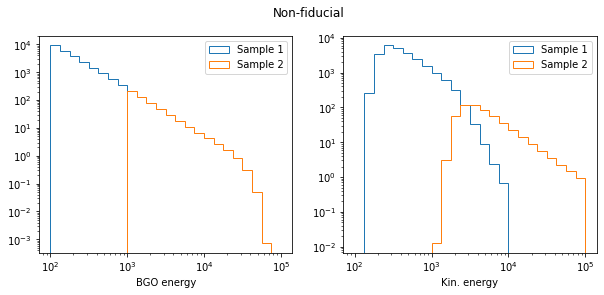

In [125]:
mp.figure(figsize=(10, 4))
mp.subplot(1, 2, 1)
for i, d in enumerate([d1, d2]):
    mp.hist(d.bgoe, bgo_ebins, weights=d.weights,
            histtype='step', label=f'Sample {i+1}')
mp.legend()
mp.xscale('log')
mp.yscale('log')
mp.xlabel('BGO energy')

mp.subplot(1, 2, 2)
for i, d in enumerate([d1, d2]):
    mp.hist(d.eprim, prim_ebins, weights=d.weights,
            histtype='step', label=f'Sample {i+1}')
mp.legend()
mp.xscale('log')
mp.yscale('log')
mp.xlabel('Kin. energy')

mp.suptitle('Non-fiducial')

mp.show()

In [127]:
bgo_ebins = np.logspace(2, 5, 25)
bgo_ebinc = (bgo_ebins[:-1] + bgo_ebins[1:]) / 2.
prim_ebins = np.logspace(2, 5, 25)
prim_ebinc = (prim_ebins[:-1] + prim_ebins[1:]) / 2.

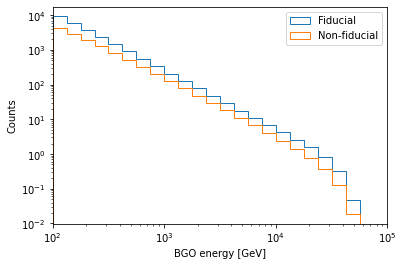

In [128]:
mp.hist(d_f.bgoe, bgo_ebins, weights=d_f.weights, 
        histtype='step', label='Fiducial')
mp.hist(d_nf.bgoe, bgo_ebins, weights=d_nf.weights, 
        histtype='step', label='Non-fiducial')
mp.legend()
mp.xscale('log')
mp.yscale('log')
mp.xlabel('BGO energy [GeV]')
mp.xlim(bgo_ebins[0], bgo_ebins[-1])
mp.ylabel('Counts')
mp.show()

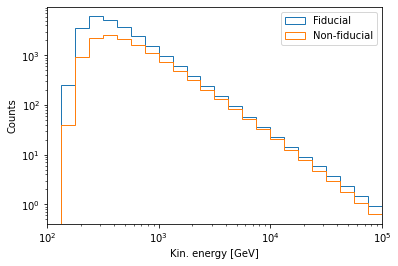

In [129]:
mp.hist(d_f.eprim, prim_ebins, weights=d_f.weights, 
        histtype='step', label='Fiducial')
mp.hist(d_nf.eprim, prim_ebins, weights=d_nf.weights, 
        histtype='step', label='Non-fiducial')
mp.legend()
mp.xscale('log')
mp.yscale('log')
mp.xlabel('Kin. energy [GeV]')
mp.xlim(prim_ebins[0], prim_ebins[-1])
mp.ylabel('Counts')
mp.show()

<ipython-input-130-69303af55570>:4: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  mp.hist2d(d.eprim, d.bgoe / d.eprim,
<ipython-input-130-69303af55570>:11: RuntimeWarning: Mean of empty slice.
  mean[ie] = (d.bgoe / d.eprim)[(d.eprim > emin) & (d.eprim < emax)].mean()
/Users/stolpovs/anaconda2/envs/root_env/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-130-69303af55570>:4: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  mp.hist2d(d.eprim, d.bgoe / d.eprim,
<ipython-input-130-69303af55570>:11: RuntimeWarning: Mean of empty slice

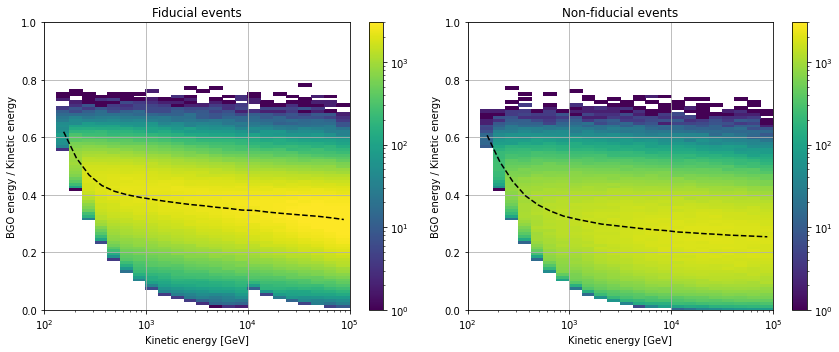

In [130]:
mp.figure(figsize=(12, 5))
for i, d in enumerate([d_f, d_nf]):
    mp.subplot(1, 2, i+1)
    mp.hist2d(d.eprim, d.bgoe / d.eprim, 
              (prim_ebins, np.linspace(0, 1, 100)),
              vmin=1e0, vmax=3e3,
              norm=LogNorm())
    mean = np.empty(len(prim_ebinc))
    for ie, (emin, emax) in enumerate(zip(prim_ebins[:-1],
                                          prim_ebins[1:])):
        mean[ie] = (d.bgoe / d.eprim)[(d.eprim > emin) & (d.eprim < emax)].mean()
    mp.plot(prim_ebinc, mean, 'k--')
    mp.colorbar()
    mp.xlabel('Kinetic energy [GeV]')
    mp.ylabel('BGO energy / Kinetic energy')
    mp.xscale('log')
    mp.title(['Fiducial events', 'Non-fiducial events'][i])
    mp.grid()
mp.tight_layout()
mp.show()

## Unfolding

For doing unfolding we need the following ingredients:
1. primary energy and BGO energy ditributions for He candidates selected
     from He MC sample same way as we do for data. This is needed for 
     building the response (or unfolding) matrix
2. efficiencies and their uncertainties dependent on the primary energy
3. helium counts from data and their errors

Here we follow the example from 
https://jrbourbeau.github.io/pyunfold/notebooks/tutorial.html


In [145]:
def get_flux(d, efficiency=None, prior=None):
    true_samples = np.histogram(d.eprim, prim_ebins, weights=d.weights)[0]
    observed_samples = np.histogram(d.bgoe, bgo_ebins, weights=d.weights)[0]
    
    # In the real analysis you have a choice to either
    # provide the efficiency to the pyunfold
    # or to divide by the efficiency afterwards
    # MISHA: So far I didn't see any difference between the two approaches
    if efficiency is None:
        efficiency = np.ones(len(prim_ebinc))
    efficiency_err = np.zeros(len(prim_ebinc))
    
    # Build the response matrix
    response_hist, _, _ = np.histogram2d(d.bgoe, d.eprim,
                                         weights=d.weights,
                                         bins=[bgo_ebins, prim_ebins])
    # In real life the errors are smaller and are
    # defined by the unweighted MC statistics that we have
    response_hist_err = np.sqrt(response_hist)
    column_sums = response_hist.sum(axis=0)
    normalization_factor = efficiency / column_sums
    response = response_hist * normalization_factor
    response_err = response_hist_err * normalization_factor
    
    # Show the responce matrix on a plot
    fig, ax = mp.subplots()
    im = ax.imshow(response, origin='lower', norm=LogNorm())
    cbar = mp.colorbar(im)
    ax.set(xlabel='Kinetic energy bins', 
           ylabel='BGO energy bins')
#     x=range(len(bgo_ebins))
#     mp.plot(x,x,'k--')
    mp.show()
    
    # pyunfold doesn't like NaNs
    response[~np.isfinite(response)] = 0
    response_err[~np.isfinite(response_err)] = 0
    efficiency[~np.isfinite(efficiency)] = 1.
    
    #iterative_unfold returns a dictionary that contains:
    # -Unfolded distribution (unfolded key)
    # -Statistical uncertainties on the unfolded distribution (stat_err key)
    # -Systematic uncertainties on the unfolded distribution based on the response matrix uncertainties (sys_err key)
    # -Number of unfolding iterations to reach test statistic stopping condition (num_iterations key)
    # -Test statistic value for final iteration (ts_iter key)
    # -Test statistic stopping condition (ts_stopping key)
    # -Unfolding matrix (unfolding_matrix key)
    unfolded_results = iterative_unfold(data=observed_samples,
                                    data_err=true_samples,
                                    response=response,
                                    response_err=response_err,
                                    efficiencies=efficiency,
                                    efficiencies_err=efficiency_err,
                                    prior=prior,
                                    callbacks=[Logger()])
    return unfolded_results

In [146]:
from pyunfold.priors import jeffreys_prior
jeff_prior = jeffreys_prior(prim_ebinc)

<ipython-input-145-5916067a828f>:21: RuntimeWarning: divide by zero encountered in true_divide
  normalization_factor = efficiency / column_sums
<ipython-input-145-5916067a828f>:22: RuntimeWarning: invalid value encountered in multiply
  response = response_hist * normalization_factor
<ipython-input-145-5916067a828f>:23: RuntimeWarning: invalid value encountered in multiply
  response_err = response_hist_err * normalization_factor


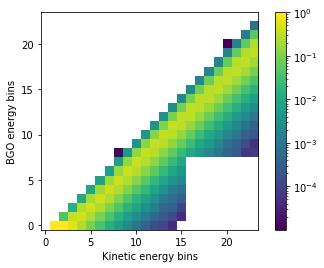

Iteration 1: ts = 0.2833, ts_stopping = 0.01
Iteration 2: ts = 0.0485, ts_stopping = 0.01
Iteration 3: ts = 0.0225, ts_stopping = 0.01
Iteration 4: ts = 0.0128, ts_stopping = 0.01
Iteration 5: ts = 0.0083, ts_stopping = 0.01


In [147]:
unfolded_results_f = get_flux(d_f, prior=jeff_prior)

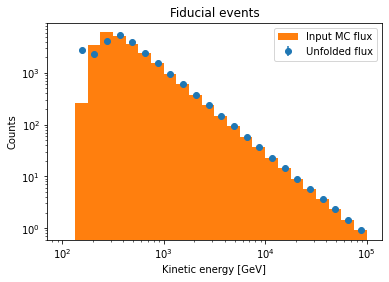

In [151]:
err = np.sqrt(unfolded_results_f['stat_err']**2 + unfolded_results_f['sys_err']**2)
mp.errorbar(prim_ebinc, unfolded_results_f['unfolded'], #yerr = err)
            yerr=unfolded_results_f['sys_err'],
            fmt='o', label='Unfolded flux')
mp.hist(d_f.eprim, prim_ebins, weights=d_f.weights, label='Input MC flux')
mp.legend()
mp.xscale('log')
mp.yscale('log')
mp.xlabel('Kinetic energy [GeV]')
mp.ylabel('Counts')
mp.title('Fiducial events')
mp.show()

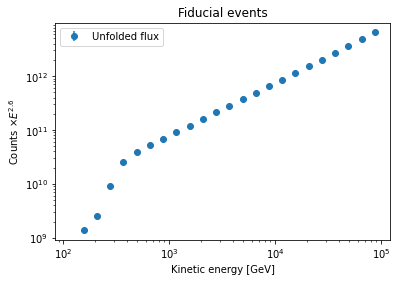

In [152]:
mp.errorbar(prim_ebinc,
            unfolded_results_f['unfolded'] * prim_ebinc**2.6,
            yerr=unfolded_results_f['sys_err'] * prim_ebinc**2.6,
            fmt='o', label='Unfolded flux')
mp.legend()
mp.xscale('log')
mp.yscale('log')
mp.xlabel('Kinetic energy [GeV]')
mp.ylabel('Counts $\\times E^{2.6}$')
mp.title('Fiducial events')
mp.show()

<ipython-input-153-18e936ea99d6>:1: RuntimeWarning: invalid value encountered in true_divide
  eff = np.histogram(d_nf.eprim, prim_ebins)[0] / \


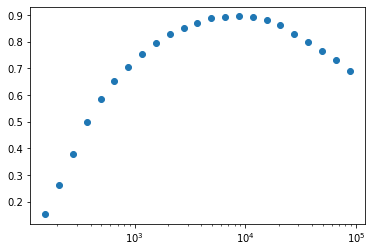

In [153]:
eff = np.histogram(d_nf.eprim, prim_ebins)[0] / \
      np.histogram(d_f.eprim, prim_ebins)[0]
mp.plot(prim_ebinc, eff, 'o')
mp.xscale('log')
mp.show()

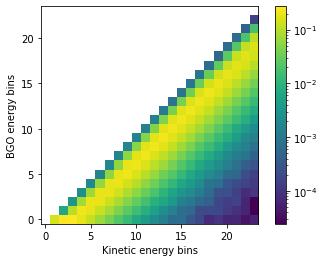

Iteration 1: ts = 0.2504, ts_stopping = 0.01
Iteration 2: ts = 0.0368, ts_stopping = 0.01
Iteration 3: ts = 0.0242, ts_stopping = 0.01
Iteration 4: ts = 0.0165, ts_stopping = 0.01
Iteration 5: ts = 0.0119, ts_stopping = 0.01
Iteration 6: ts = 0.0091, ts_stopping = 0.01


In [154]:
unfolded_results_nf = get_flux(d_nf, efficiency=eff, prior=jeff_prior)

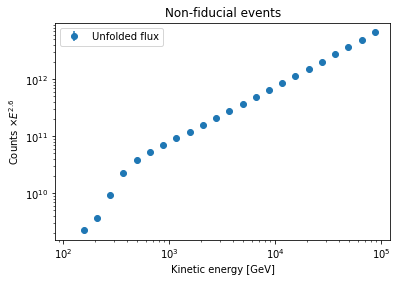

In [155]:
mp.errorbar(prim_ebinc,
            unfolded_results_nf['unfolded'] * prim_ebinc**2.6,
            yerr=unfolded_results_nf['sys_err'] * prim_ebinc**2.6,
            fmt='o', label='Unfolded flux')
mp.legend()
mp.xscale('log')
mp.yscale('log')
mp.xlabel('Kinetic energy [GeV]')
mp.ylabel('Counts $\\times E^{2.6}$')
mp.title('Non-fiducial events')
mp.show()

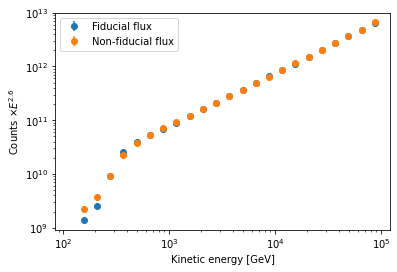

In [156]:
mp.errorbar(prim_ebinc,
            unfolded_results_f['unfolded'] * prim_ebinc**2.6,
            yerr=unfolded_results_f['sys_err'] * prim_ebinc**2.6,
            fmt='o', label='Fiducial flux')
mp.errorbar(prim_ebinc,
            unfolded_results_nf['unfolded'] * prim_ebinc**2.6,
            yerr=unfolded_results_nf['sys_err'] * prim_ebinc**2.6,
            fmt='o', label='Non-fiducial flux')
mp.legend()
mp.xscale('log')
mp.yscale('log')
mp.xlabel('Kinetic energy [GeV]')
mp.ylabel('Counts $\\times E^{2.6}$')
mp.show()

<ipython-input-158-28d22477c463>:3: RuntimeWarning: invalid value encountered in true_divide
  (unfolded_results_f['unfolded'] - h) / h,
<ipython-input-158-28d22477c463>:7: RuntimeWarning: invalid value encountered in true_divide
  (unfolded_results_nf['unfolded'] - h) / h,


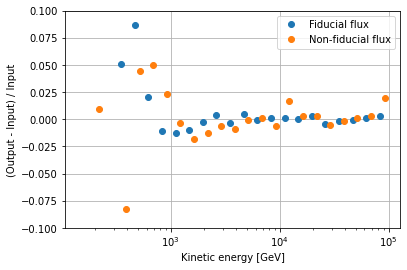

In [158]:
h = np.histogram(d_f.eprim, prim_ebins, weights=d_f.weights)[0]
mp.errorbar(prim_ebinc * 0.95,
            (unfolded_results_f['unfolded'] - h) / h,
#             yerr=(unfolded_results_f['sys_err'] - h) / h,
            fmt='o', label='Fiducial flux')
mp.errorbar(prim_ebinc * 1.05,
            (unfolded_results_nf['unfolded'] - h) / h,
#             yerr=(unfolded_results_nf['sys_err'] - h) / h,
            fmt='o', label='Non-fiducial flux')
mp.legend()
mp.xscale('log')
mp.ylim(-0.1, 0.1)
mp.xlabel('Kinetic energy [GeV]')
mp.ylabel('(Output - Input) / Input')
mp.grid()
mp.show()

# Try with smoothly broken power law weights

Broken power law formula:

$f(x) = A x^{-\gamma} \left( \frac{1}{2} \left( 1 + \frac{x}{x_b} \right)^s \right )^{\Delta \gamma / s}$

where 
- $\gamma$ - spectral indices before the break (for DAMPE it is 2.4)
- $x_b$ is the break position (34TeV)
- $s$ is smoothening parameter (5)

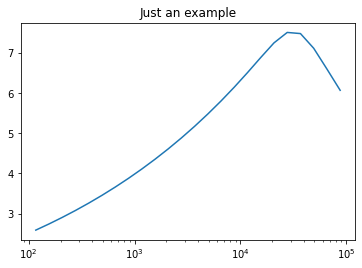

In [159]:
f = lambda x, xb, g, dg, s: x**(-g) * (1 + (x / xb)**s)**(dg / s)
g = 2.4
dg = -0.5
xb = 34000
s = 5
mp.plot(prim_ebinc, f(prim_ebinc, xb, g, dg, s)*prim_ebinc**2.6)
mp.xscale('log')
mp.title('Just an example')
mp.show()

 13%|█▎        | 32/249 [00:00<00:00, 316.90it/s]

Calculating weigths


 19%|█▉        | 48/249 [00:00<00:00, 472.74it/s]

Calculating weigths


100%|██████████| 249/249 [00:00<00:00, 394.69it/s]


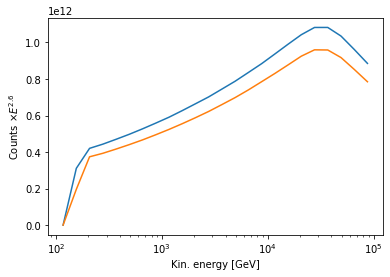

In [160]:
def broken_power_law(x):
    g = 2.4
    dg = -0.5
    xb = 34000
    s = 5
    return x**(-g) * (1 + (x / xb)**s)**(dg / s)
for d in [d_f, d_nf]:
    d.isMC = True
    d.prim_ebins = prim_ebins
    d.primE = d.eprim
    d.set_weights(broken_power_law)
    h = np.histogram(d.eprim, prim_ebins, weights=d.weights)[0]
    mp.plot(prim_ebinc, h * prim_ebinc**2.6)
mp.xscale('log')
mp.xlabel('Kin. energy [GeV]')
mp.ylabel('Counts $\\times E^{2.6}$')
mp.show()

<ipython-input-145-5916067a828f>:21: RuntimeWarning: divide by zero encountered in true_divide
  normalization_factor = efficiency / column_sums
<ipython-input-145-5916067a828f>:22: RuntimeWarning: invalid value encountered in multiply
  response = response_hist * normalization_factor
<ipython-input-145-5916067a828f>:23: RuntimeWarning: invalid value encountered in multiply
  response_err = response_hist_err * normalization_factor


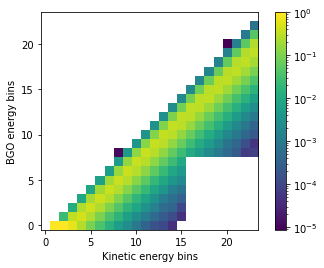

Iteration 1: ts = 0.2504, ts_stopping = 0.01
Iteration 2: ts = 0.0420, ts_stopping = 0.01
Iteration 3: ts = 0.0150, ts_stopping = 0.01
Iteration 4: ts = 0.0070, ts_stopping = 0.01


In [161]:
unfolded_results_f = get_flux(d_f, prior=jeff_prior)

<ipython-input-162-5f409a7909ca>:1: RuntimeWarning: invalid value encountered in true_divide
  eff = np.histogram(d_nf.eprim, prim_ebins)[0] / \


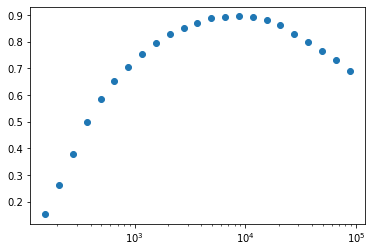

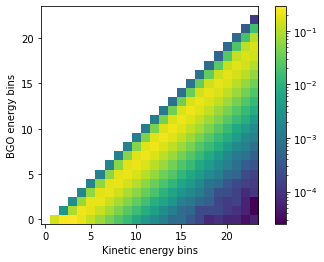

Iteration 1: ts = 0.2504, ts_stopping = 0.01
Iteration 2: ts = 0.0671, ts_stopping = 0.01
Iteration 3: ts = 0.0312, ts_stopping = 0.01
Iteration 4: ts = 0.0174, ts_stopping = 0.01
Iteration 5: ts = 0.0109, ts_stopping = 0.01
Iteration 6: ts = 0.0074, ts_stopping = 0.01


In [162]:
eff = np.histogram(d_nf.eprim, prim_ebins)[0] / \
      np.histogram(d_f.eprim, prim_ebins)[0]
mp.plot(prim_ebinc, eff, 'o')
mp.xscale('log')
mp.show()
unfolded_results_nf = get_flux(d_nf, efficiency=eff, prior=jeff_prior)

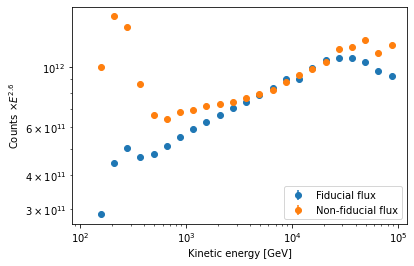

In [163]:
mp.errorbar(prim_ebinc,
            unfolded_results_f['unfolded'] * prim_ebinc**2.6,
            yerr=unfolded_results_f['sys_err'] * prim_ebinc**2.6,
            fmt='o', label='Fiducial flux')
mp.errorbar(prim_ebinc,
            unfolded_results_nf['unfolded'] * prim_ebinc**2.6,
            yerr=unfolded_results_nf['sys_err'] * prim_ebinc**2.6,
            fmt='o', label='Non-fiducial flux')
mp.legend()
mp.xscale('log')
mp.yscale('log')
mp.xlabel('Kinetic energy [GeV]')
mp.ylabel('Counts $\\times E^{2.6}$')
mp.show()

<ipython-input-164-e9ae45f9d4f5>:3: RuntimeWarning: invalid value encountered in true_divide
  (unfolded_results_f['unfolded'] - h) / h,
<ipython-input-164-e9ae45f9d4f5>:7: RuntimeWarning: invalid value encountered in true_divide
  (unfolded_results_nf['unfolded'] - h) / h,


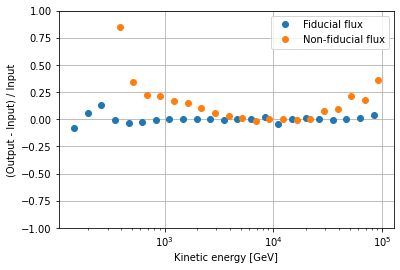

In [164]:
h = np.histogram(d_f.eprim, prim_ebins, weights=d_f.weights)[0]
mp.errorbar(prim_ebinc * 0.95,
            (unfolded_results_f['unfolded'] - h) / h,
#             yerr=(unfolded_results_f['sys_err'] - h) / h,
            fmt='o', label='Fiducial flux')
mp.errorbar(prim_ebinc * 1.05,
            (unfolded_results_nf['unfolded'] - h) / h,
#             yerr=(unfolded_results_nf['sys_err'] - h) / h,
            fmt='o', label='Non-fiducial flux')
mp.legend()
mp.xscale('log')
mp.ylim(-1, 1)
mp.xlabel('Kinetic energy [GeV]')
mp.ylabel('(Output - Input) / Input')
mp.grid()
mp.show()

# And now try the sum of fiducial and non-fiducial samples

In [165]:
d_tot = d_f + d_nf
d_tot.set_weights(broken_power_law)

  7%|▋         | 18/249 [00:00<00:01, 176.65it/s]

Calculating weigths


100%|██████████| 249/249 [00:01<00:00, 161.41it/s]


<ipython-input-145-5916067a828f>:21: RuntimeWarning: divide by zero encountered in true_divide
  normalization_factor = efficiency / column_sums
<ipython-input-145-5916067a828f>:22: RuntimeWarning: invalid value encountered in multiply
  response = response_hist * normalization_factor
<ipython-input-145-5916067a828f>:23: RuntimeWarning: invalid value encountered in multiply
  response_err = response_hist_err * normalization_factor


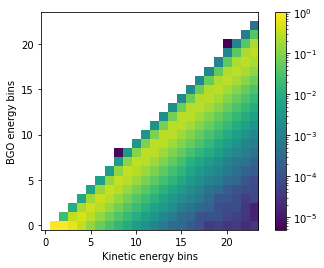

Iteration 1: ts = 0.2504, ts_stopping = 0.01
Iteration 2: ts = 0.0461, ts_stopping = 0.01
Iteration 3: ts = 0.0171, ts_stopping = 0.01
Iteration 4: ts = 0.0079, ts_stopping = 0.01


In [166]:
unfolded_results_tot = get_flux(d_tot, prior=jeff_prior)

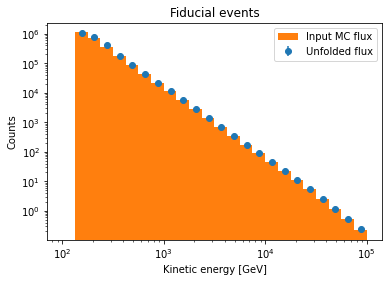

In [167]:
err = np.sqrt(unfolded_results_tot['stat_err']**2 + unfolded_results_tot['sys_err']**2)
mp.errorbar(prim_ebinc, unfolded_results_tot['unfolded'], #yerr = err)
            yerr=unfolded_results_tot['sys_err'],
            fmt='o', label='Unfolded flux')
mp.hist(d_tot.eprim, prim_ebins, weights=d_tot.weights, label='Input MC flux')
mp.legend()
mp.xscale('log')
mp.yscale('log')
mp.xlabel('Kinetic energy [GeV]')
mp.ylabel('Counts')
mp.title('Fiducial events')
mp.show()

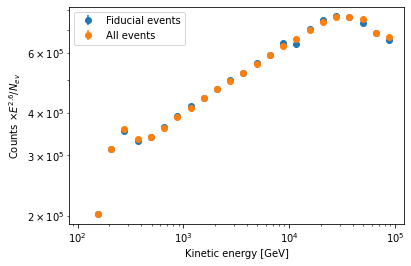

In [168]:
mp.errorbar(prim_ebinc,
            unfolded_results_f['unfolded'] * prim_ebinc**2.6 / len(d_f),
            yerr=unfolded_results_f['sys_err'] * prim_ebinc**2.6 / len(d_f),
            fmt='o', label='Fiducial events')
mp.errorbar(prim_ebinc,
            unfolded_results_tot['unfolded'] * prim_ebinc**2.6 / len(d_tot),
            yerr=unfolded_results_tot['sys_err'] * prim_ebinc**2.6 / len(d_tot),
            fmt='o', label='All events')
mp.legend()
mp.xscale('log')
mp.yscale('log')
mp.xlabel('Kinetic energy [GeV]')
mp.ylabel('Counts $\\times E^{2.6} / N_{ev}$')
mp.show()

<ipython-input-169-d01604512a3a>:3: RuntimeWarning: invalid value encountered in true_divide
  (unfolded_results_f['unfolded'] - h) / h,
<ipython-input-169-d01604512a3a>:8: RuntimeWarning: invalid value encountered in true_divide
  (unfolded_results_tot['unfolded'] - h) / h,


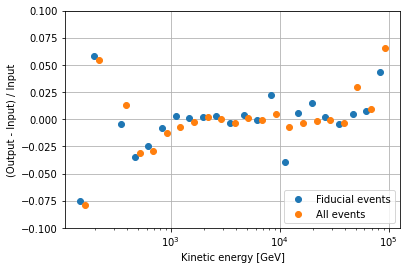

In [169]:
h = np.histogram(d_f.eprim, prim_ebins, weights=d_f.weights)[0]
mp.errorbar(prim_ebinc * 0.95,
            (unfolded_results_f['unfolded'] - h) / h,
#             yerr=(unfolded_results_f['sys_err'] - h) / h,
            fmt='o', label='Fiducial events')
h = np.histogram(d_tot.eprim, prim_ebins, weights=d_tot.weights)[0]
mp.errorbar(prim_ebinc * 1.05,
            (unfolded_results_tot['unfolded'] - h) / h,
#             yerr=(unfolded_results_tot['sys_err'] - h) / h,
            fmt='o', label='All events')
mp.legend()
mp.xscale('log')
mp.ylim(-0.1, 0.1)
mp.xlabel('Kinetic energy [GeV]')
mp.ylabel('(Output - Input) / Input')
mp.grid()
mp.show()

In [109]:
f = rt.TFile(path + "EngNtup_AnaNtupNucFid_allHe4-v6r0p10_skim_100GeV_1TeV.root")
t = f.Get('EngNtup')
t.Print()

******************************************************************************
*Tree    :EngNtup   : EngNtup                                                *
*Entries :   495552 : Total =      1002214259 bytes  File  Size =  624839241 *
*        :          : Tree compression factor =   1.60                       *
******************************************************************************
*Br    0 :dd_evtPoid : dd_evtPoid/F                                          *
*Entries :   495552 : Total  Size=    1985133 bytes  File Size  =    1782097 *
*Baskets :       26 : Basket Size=      32000 bytes  Compression=   1.11     *
*............................................................................*
*Br    1 :dd_bgoTotalE_GeV : dd_bgoTotalE_GeV/F                              *
*Entries :   495552 : Total  Size=    1985313 bytes  File Size  =    1755339 *
*Baskets :       26 : Basket Size=      32000 bytes  Compression=   1.13     *
*...................................................